# IIT

In [1]:
import torch
import random
import copy
import itertools
import numpy as np
import utils
from trainer import BERTLIMTrainer

from sklearn.metrics import classification_report
from LIM_bert import LIMBERTClassifier
import dataset_nli

from transformers import BertModel, BertTokenizer
utils.fix_random_seeds()

c:\Users\amirz\.conda\envs\interchange\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## IIT MoNLI

In [2]:
from ii_benchmark import IIBenchmarkMoNli

num_layers = 12
hidden_dim = 768
data_size = 120
test_data_size = 90
device = 'cuda:0'
seed = 42

iit_layer = 6
hidden_dim_per_concept = 256

intervention_ids_to_coords = {
    0:[{"layer":iit_layer, "start":0, "end":hidden_dim_per_concept}],
    1:[{"layer":iit_layer, "start":hidden_dim_per_concept, "end":2*hidden_dim_per_concept}],
    2:[{"layer":iit_layer, "start":0, "end":hidden_dim_per_concept},
        {"layer":iit_layer, "start":hidden_dim_per_concept, "end":2*hidden_dim_per_concept}],
}

benchmark = IIBenchmarkMoNli(
    variable_names=['LEX'],
    data_parameters={
        'train_size': data_size, 'test_size': test_data_size
    },
    model_parameters={
        'weights_name': 'ishan/bert-base-uncased-mnli',
        'max_length': 128,
        'n_classes': 2,
        'hidden_dim': 768,
        'target_layers' : [iit_layer],
        'target_dims':{
            "start" : 0,
            "end" : 786,
        },
        'debug':False, 
        'device': device,
        'static_search': False,
        'nested_disentangle_inplace': False
    },
    training_parameters={
        'warm_start': False, 'max_iter': 5, 'batch_size': 4, 'n_iter_no_change': 10, 
        'shuffle_train': False, 'eta': 0.002, 'device': device
    },
    seed=seed
)

In [3]:
LIM_bert = benchmark.create_model()

Some weights of the model checkpoint at ishan/bert-base-uncased-mnli were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
LIM_trainer = benchmark.create_classifier(LIM_bert)
LIM_trainer.model.set_analysis_mode(False)

In [5]:
def get_eval_from_train_nli(iit_nli_dataset, n=1000, control=False):
    base_test, y_base_test, sources_test, y_IIT_test, intervention_ids_test = iit_nli_dataset
    
    if control:
        if len(sources_test) == 1:
            
            
            indices = torch.randperm(len(base_test[0])) # within each bucket, we randomize!
            indices = indices[:n]
            
            return (
                (
                    [base_test[0][ind] for ind in indices], 
                    [base_test[1][ind] for ind in indices], 
                ), 
                y_base_test[indices], 
                [
                    (
                        [sources_test[0][0][ind] for ind in indices],
                        [sources_test[0][1][ind] for ind in indices]
                    )
                ], 
                y_IIT_test[indices], 
                intervention_ids_test[indices], 
            )
        else:
            
            assert n % 3 == 0
            sub_n = n // 3
            sub_dataset_size = len(base_test[0]) // 3
            indices = torch.randperm(sub_dataset_size) # within each bucket, we randomize!
            indices = indices[:sub_n]
            indices2 = indices + sub_dataset_size
            indices3 = indices2 + sub_dataset_size
            indices = torch.cat([indices, indices2, indices3])
            
            return (
                (
                    [base_test[0][ind] for ind in indices], 
                    [base_test[1][ind] for ind in indices], 
                ), 
                y_base_test[indices], 
                [
                    (
                        [sources_test[0][0][ind] for ind in indices],
                        [sources_test[0][1][ind] for ind in indices]
                    ),
                    (
                        [sources_test[1][0][ind] for ind in indices],
                        [sources_test[1][1][ind] for ind in indices]
                    )
                ], 
                y_IIT_test[indices], 
                intervention_ids_test[indices], 
            )
    else:
        pass

def get_IIT_nli_dataset_factual_pairs(
    data_size,
    tokenizer_name,
    split="train",
):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        if X[0][-1] != ".":
            input = [". ".join(X)]
        else:
            input = [" ".join(X)]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    dataset = dataset_nli.IIT_MoNLIDataset(
        embed_func=encoding,
        suffix=split,
        size=data_size)
    
    X_base, y_base = dataset.create_factual_pairs()
    y_base = torch.tensor(y_base)
    return X_base, y_base

def get_IIT_nli_dataset_neghyp_V1(
    data_size,
    tokenizer_name,
    split="train",
):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        if X[0][-1] != ".":
            input = [". ".join(X)]
        else:
            input = [" ".join(X)]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    dataset = dataset_nli.IIT_MoNLIDataset(
        embed_func=encoding,
        suffix=split,
        size=data_size)
    
    X_base, y_base, X_sources,  y_IIT, interventions = dataset.create_neghyp_V1()
    y_base = torch.tensor(y_base)
    y_IIT = torch.tensor(y_IIT)
    interventions = torch.tensor(interventions)
    return X_base, y_base, X_sources,  y_IIT, interventions

def get_IIT_nli_dataset_neghyp_V2(
    data_size,
    tokenizer_name,
    split="train",
):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        if X[0][-1] != ".":
            input = [". ".join(X)]
        else:
            input = [" ".join(X)]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    dataset = dataset_nli.IIT_MoNLIDataset(
        embed_func=encoding,
        suffix=split,
        size=data_size)
    
    X_base, y_base, X_sources,  y_IIT, interventions = dataset.create_neghyp_V2()
    y_base = torch.tensor(y_base)
    y_IIT = torch.tensor(y_IIT)
    interventions = torch.tensor(interventions)
    return X_base, y_base, X_sources, y_IIT, interventions

def get_IIT_nli_dataset_neghyp_V1_V2(
    data_size,
    tokenizer_name,
    split="train",
):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        if X[0][-1] != ".":
            input = [". ".join(X)]
        else:
            input = [" ".join(X)]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    dataset = dataset_nli.IIT_MoNLIDataset(
        embed_func=encoding,
        suffix=split,
        size=data_size)
    
    X_base, y_base, X_sources,  y_IIT, interventions = dataset.create_neghyp_V1_V2()
    y_base = torch.tensor(y_base)
    y_IIT = torch.tensor(y_IIT)
    interventions = torch.tensor(interventions)
    return X_base, y_base, X_sources, y_IIT, interventions

def get_IIT_nli_dataset_neghyp(
    data_size,
    tokenizer_name,
    split="train",
):
    assert data_size % 3 == 0
    sub_data_size = data_size // 3
    V1_dataset = \
        get_IIT_nli_dataset_neghyp_V1(sub_data_size, tokenizer_name, split)
    V2_dataset = \
        get_IIT_nli_dataset_neghyp_V2(sub_data_size, tokenizer_name, split)
    both_dataset = \
        get_IIT_nli_dataset_neghyp_V1_V2(sub_data_size, tokenizer_name, split)
    
    X_base = (V1_dataset[0][0] + V2_dataset[0][0] + both_dataset[0][0],
     V1_dataset[0][1] + V2_dataset[0][1] + both_dataset[0][1])
    y_base = torch.cat((V1_dataset[1],
                        V2_dataset[1],
                        both_dataset[1]))
    
    X_sources = [(V1_dataset[2][0][0] + V2_dataset[2][0][0] + both_dataset[2][0][0],
    V1_dataset[2][0][1] + V2_dataset[2][0][1] + both_dataset[2][0][1]),
    (V1_dataset[2][0][0] + V2_dataset[2][0][0] + both_dataset[2][1][0],
    V1_dataset[2][0][1] + V2_dataset[2][0][1] + both_dataset[2][1][1])]
    
    y_IIT = torch.cat((V1_dataset[3],
                        V2_dataset[3],
                        both_dataset[3]))
    interventions = torch.cat((V1_dataset[4],
                        V2_dataset[4],
                        both_dataset[4]))
    
    return X_base, y_base, X_sources, y_IIT, interventions

def get_IIT_nli_dataset_tokenidentity_V1(
    data_size,
    tokenizer_name,
    split="train",
):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        if X[0][-1] != ".":
            input = [". ".join(X)]
        else:
            input = [" ".join(X)]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    dataset = dataset_nli.IIT_MoNLIDataset(
        embed_func=encoding,
        suffix=split,
        size=data_size)
    
    X_base, y_base, X_sources,  y_IIT, interventions = dataset.create_tokenidentity_V1()
    y_base = torch.tensor(y_base)
    y_IIT = torch.tensor(y_IIT)
    interventions = torch.tensor(interventions)
    return X_base, y_base, X_sources,  y_IIT, interventions

In [50]:
split = 'train'

dataset = dataset_nli.IIT_MoNLIDataset(
    embed_func=lambda x: (x, []),
    suffix=split,
    size=data_size
)

X_base, y_base, X_sources,  y_IIT, interventions = dataset.create_neghyp_V1()
y_base = torch.tensor(y_base)
y_IIT = torch.tensor(y_IIT)
interventions = torch.tensor(interventions)

In [58]:
X_base[0][0], y_base[0].item(), X_sources[0][0][0], y_IIT[0].item()

(['The person did not like bananas.', 'The person did not like fruit.'],
 1,
 ['A brown dog is shaking off the snow.',
  'A brown poodle is shaking off the snow.'],
 0)

In [6]:
train_datasetIIT = get_IIT_nli_dataset_neghyp(
    data_size=data_size, 
    split="train",
    tokenizer_name='ishan/bert-base-uncased-mnli'
)
X_base_train, y_base_train = train_datasetIIT[0:2]
iit_data = tuple(train_datasetIIT[2:])

In [8]:
_ = LIM_trainer.fit(
    X_base_train, 
    y_base_train, 
    iit_data=iit_data,
    intervention_ids_to_coords=intervention_ids_to_coords
)

Finished epoch 5 of 5; error is 46.25925278663635

In [12]:
test_data_size = 48

base_test_train, y_base_test_train, sources_test_train, y_IIT_test_train, intervention_ids_test_train = \
    get_eval_from_train_nli(
        train_datasetIIT, test_data_size, control=True
    )

base_test, y_base_test, sources_test, y_IIT_test, intervention_ids_test = get_IIT_nli_dataset_neghyp(
    data_size=test_data_size, 
    split="test",
    tokenizer_name='ishan/bert-base-uncased-mnli'
)    

In [13]:
# train data eval
base_preds_train = LIM_trainer.predict(
    base_test_train
)
IIT_preds_train = LIM_trainer.iit_predict(
    base_test_train, sources_test_train, 
    intervention_ids_test_train, 
    intervention_ids_to_coords
)

## Train Blackbox Model

In [2]:
import os

BASE = '../../local/SemEval2018-Task1-all-data/English/'
task = 'EI'
task_type = 'reg'
path = os.path.join(BASE, f'{task}-{task_type}')
os.listdir(path)

['development', 'test-gold', 'training']

In [3]:
import pandas as pd

def load_data_ei(path):
    train_df = pd.read_csv(os.path.join(path, 'training', f'EI-{task_type}-En-joy-train.txt'), delimiter='\t')
    eval_df = pd.read_csv(os.path.join(path, 'development', f'2018-EI-{task_type}-En-joy-dev.txt'), delimiter='\t')
    test_df = pd.read_csv(os.path.join(path, 'test-gold', f'2018-EI-{task_type}-En-joy-test-gold.txt'), delimiter='\t')

    if 'Intensity Class' in train_df.columns:
        classes = train_df['Intensity Class'].unique()
        class_to_label = dict(zip(classes, range(len(classes))))
        train_df['labels'] = train_df['Intensity Class'].map(class_to_label)
        eval_df['labels'] = eval_df['Intensity Class'].map(class_to_label)
        test_df['labels'] = test_df['Intensity Class'].map(class_to_label)
    else:
        train_df['labels'] = train_df['Intensity Score'].copy()
        eval_df['labels'] = eval_df['Intensity Score'].copy()
        test_df['labels'] = test_df['Intensity Score'].copy()

    rename = {
        'Tweet': 'text'
    }
    train_df = train_df[['Tweet', 'labels']].rename(columns=rename)
    eval_df = eval_df[['Tweet', 'labels']].rename(columns=rename)
    test_df = test_df[['Tweet', 'labels']].rename(columns=rename)

    return train_df, eval_df, test_df

def load_data_ec(path):
    train_df = pd.read_csv(os.path.join(path, '2018-E-c-En-train.txt'), delimiter='\t')
    eval_df = pd.read_csv(os.path.join(path, '2018-E-c-En-dev.txt'), delimiter='\t')
    test_df = pd.read_csv(os.path.join(path, '2018-E-c-En-test-gold.txt'), delimiter='\t')

    
    train_df['labels'] = train_df.apply(lambda r: r.iloc[2:].tolist(), axis=1)
    eval_df['labels'] = eval_df.apply(lambda r: r.iloc[2:].tolist(), axis=1)
    test_df['labels'] = test_df.apply(lambda r: r.iloc[2:].tolist(), axis=1)

    rename = {
        'Tweet': 'text'
    }
    train_df = train_df[['Tweet', 'labels']].rename(columns=rename)
    eval_df = eval_df[['Tweet', 'labels']].rename(columns=rename)
    test_df = test_df[['Tweet', 'labels']].rename(columns=rename)

    return train_df, eval_df, test_df

train_df, eval_df, test_df = load_data_ei(path)
train_df.shape, eval_df.shape, test_df.shape

((1616, 2), (290, 2), (1105, 2))

In [4]:
def get_semeval_dataset(df, tokenizer_name, data_size):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        # if X[0][-1] != ".":
        #     input = [". ".join(X)]
        # else:
        #     input = [" ".join(X)]
        input = [X]
        data = bert_tokenizer.batch_encode_plus(
            input,
            max_length=128,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    data = []
    for i, row in df.iterrows():
        if i == data_size:
            break
        x_base, x_mask = encoding(row['text'])
        y_base = row['labels']
        data.append((x_base, x_mask, y_base))
    
    base, base_mask, y = zip(*data)
    X_base = (base, base_mask) 
    y_base = torch.tensor(y)

    return X_base, y_base

In [5]:
from ii_benchmark import IIBenchmarkMoNli

VAR = 0

num_layers = 12
hidden_dim = 768
data_size = train_df.shape[0]
test_data_size = test_df.shape[0] - 1 # size is unfortunately 1 mod 8, and I'm too lazy to edit prediction code
device = 'cuda:0'
seed = 42

iit_layer = 10
hidden_dim_per_concept = 256

intervention_ids_to_coords = {
    VAR: [{"layer":iit_layer, "start":0, "end":hidden_dim_per_concept}]
}

benchmark = IIBenchmarkMoNli(
    variable_names=['GEN'],
    data_parameters={
        'train_size': data_size, 'test_size': test_data_size
    },
    model_parameters={
        'weights_name': 'bert-base-uncased',
        'max_length': 128,
        'n_classes': 1,
        'hidden_dim': 768,
        'target_layers' : [iit_layer],
        'target_dims':{
            "start" : 0,
            "end" : 786,
        },
        'debug':False, 
        'device': device,
        'static_search': False,
        'nested_disentangle_inplace': False
    },
    training_parameters={
        'warm_start': False, 'max_iter': 200, 'batch_size': 8, 'n_iter_no_change': 10, 
        'shuffle_train': False, 'eta': 2e-5, 'device': device, 'save_checkpoint_per_epoch': True
    },
    seed=seed
)

In [6]:
LIM_bert = benchmark.create_model().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
LIM_trainer = benchmark.create_classifier(LIM_bert)
LIM_trainer.model.set_analysis_mode(False)

In [8]:
X_semeval_train, y_semeval_train = get_semeval_dataset(train_df, 'bert-base-uncased', data_size)

In [9]:
_ = LIM_trainer.fit(
    X_semeval_train,
    y_semeval_train
)

Finished epoch 29 of 200; error is 0.9367132114712149

In [11]:
# torch.save(LIM_trainer.model.state_dict(), 'semeval-blackbox-layer-10.pt')

In [53]:
# import torch

# model_name = 'semeval-blackbox.pt'

# LIM_trainer.model.load_state_dict(state_dict=torch.load(model_name))

<All keys matched successfully>

In [10]:
X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict(
    X_semeval_test
)

In [11]:
from scipy.stats import pearsonr

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6872790101317944, pvalue=3.5866423438862177e-155)

## Evaluate Bias on EEC

In [5]:
EEC_PATH = 'eec_blackbox.csv'

class EEC_Dataset:
    def __init__(self, embed_func, emotions=['joy']) -> None:
        self.eec_df = pd.read_csv(EEC_PATH)
        self.embed_func = embed_func
        self.emotions = emotions

        self.eec_df = self.eec_df[(self.eec_df['Emotion'].isin(emotions)) | (self.eec_df['Emotion'].isna())]

        self._setup()

    def _setup(self):
        self.templates = self.eec_df['Template'].unique()
        self.emotion_situation_words = self.eec_df[
            self.eec_df['Template'].apply(lambda t: '<emotional situation word>' in t)
        ]['Emotion word'].unique()
        self.emotion_words = self.eec_df[
            self.eec_df['Template'].apply(lambda t: '<emotion word>' in t)
        ]['Emotion word'].unique()

        nouns = self.eec_df['Person'].unique()
        pro_nouns = [p for p in nouns if p[0].islower()]
        offset = (len(pro_nouns) - 2) // 2
        pronoun_matching = {
            pro_nouns[i]: pro_nouns[i + offset] for i in range(offset)
        }
        pronoun_matching.update({ 'him': 'her' })
        self.pronoun_matching = pronoun_matching

        proper_nouns = {
            'male': [p for p in self.eec_df[self.eec_df['Gender'] == 'male']['Person'].unique() if p[0].isupper()],
            'female': [p for p in self.eec_df[self.eec_df['Gender'] == 'female']['Person'].unique() if p[0].isupper()]
        }
        self.proper_nouns = proper_nouns

    def _get_pairs_dataset(self):
        pairs_data = []
        columns = ['Sentence_M', 'Sentence_F', 'Template', 'Emotion', 'Emotion Word', 'Person']
        for template in self.templates:
            if '<emotional situation word>' in template:
                emotion_list = self.emotion_situation_words
            elif '<emotion word>' in template:
                emotion_list = self.emotion_words
            else:
                emotion_list = [None]

            for w in emotion_list:
                if w is None:
                    state_df = self.eec_df[(self.eec_df['Template'] == template)]
                else:
                    state_df = self.eec_df[(self.eec_df['Emotion word'] == w) & (self.eec_df['Template'] == template)]

                for base_pronoun, flip_pronoun in self.pronoun_matching.items():
                    if (base_pronoun == 'he' and '<person subject>' not in template) or \
                        (base_pronoun == 'him' and '<person object>' not in template):
                        continue
                    
                    # ensure that we only have one of each noun
                    assert(state_df[state_df['Person'] == base_pronoun].shape[0] == 1)

                    pairs_data.append([
                        state_df[state_df['Person'] == base_pronoun].iloc[0]['Sentence'],
                        state_df[state_df['Person'] == flip_pronoun].iloc[0]['Sentence'],
                        template,
                        state_df[state_df['Person'] == flip_pronoun].iloc[0]['Emotion'],
                        w, 
                        'pronoun'
                    ])

                pairs_data.append([
                    [
                        state_df[state_df['Person'] == male_proper_noun].iloc[0]['Sentence']
                        for male_proper_noun in self.proper_nouns['male']
                    ],
                    [
                        state_df[state_df['Person'] == female_proper_noun].iloc[0]['Sentence']
                        for female_proper_noun in self.proper_nouns['female']
                    ],
                    template,
                    state_df.iloc[0]['Emotion'],
                    w,
                    'proper noun'
                ])

        pairs_df = pd.DataFrame(pairs_data, columns=columns)
        return pairs_df

    def get_dataset(self, variable):
        pairs_df = self._get_pairs_dataset()
        pronoun_data = []
        proper_noun_data = []
        for i, row in pairs_df.iterrows():
            if row['Person'] == 'pronoun':
                if variable == 'male':
                    base_x, base_mask = self.embed_func(row['Sentence_M'])
                else:
                    base_x, base_mask = self.embed_func(row['Sentence_F'])
                pronoun_data.append((base_x, base_mask))
            else:
                if variable == 'male':
                    embedded = [self.embed_func(s) for s in row['Sentence_M']]
                else:
                    embedded = [self.embed_func(s) for s in row['Sentence_F']]
                base_x, base_mask = zip(*embedded)
                proper_noun_data.append((base_x, base_mask))
        
        base_pronoun, base_mask_pronoun = zip(*pronoun_data)
        self.base_pronoun = base_pronoun
        self.base_mask_pronoun = base_mask_pronoun

        base_proper_noun, base_mask_proper_noun = zip(*proper_noun_data)
        self.base_proper_noun = base_proper_noun
        self.base_mask_proper_noun = base_mask_proper_noun
        return (self.base_pronoun, self.base_mask_pronoun), (self.base_proper_noun, self.base_mask_proper_noun)

In [6]:
def get_EEC_dataset(tokenizer_name):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

    def encoding(X):
        input = [X]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    eec_dataset = EEC_Dataset(embed_func=encoding)

    pronoun_dataset_m, proper_noun_dataset_m = eec_dataset.get_dataset('male')
    pronoun_dataset_f, proper_noun_dataset_f = eec_dataset.get_dataset('female')

    return pronoun_dataset_m, proper_noun_dataset_m, pronoun_dataset_f, proper_noun_dataset_f

In [7]:
def evaluate_on_EEC(LIM_trainer, dataset):
    pronoun_dataset_m, proper_noun_dataset_m, pronoun_dataset_f, proper_noun_dataset_f = dataset

    predictions_m = LIM_trainer.predict(pronoun_dataset_m)
    predictions_f = LIM_trainer.predict(pronoun_dataset_f)

    for x_m in zip(*proper_noun_dataset_m):
        predictions_m = torch.cat((
            predictions_m,
            LIM_trainer.predict(x_m).mean().unsqueeze(0)
        ))
    
    for x_f in zip(*proper_noun_dataset_f):
        predictions_f = torch.cat((
            predictions_f,
            LIM_trainer.predict(x_f).mean().unsqueeze(0)
        ))
    
    return predictions_m, predictions_f

In [ ]:
eec_dataset = get_EEC_dataset('bert-base-uncased')
predictions_m, predictions_f = evaluate_on_EEC(LIM_trainer, eec_dataset)

predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [17]:
print(predictions_m.mean(), predictions_f.mean())

0.54950637 0.50484943


In [18]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.951048951048951


In [19]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=5.595999557050003, pvalue=2.9530968589044692e-08)

In [20]:
def get_EEC_sentence_inputs(tokenizer_name):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

    def encoding(X):
        input = [X]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    eec_df = pd.read_csv(EEC_PATH)

    data = []
    for sentence in eec_df['Sentence'].values:
        data.append(encoding(sentence))
    
    inputs, masks = zip(*data)

    return inputs, masks

In [21]:
# X_eec = get_EEC_sentence_inputs('bert-base-uncased')

# blackbox_preds = LIM_trainer.predict(X_eec) 

In [22]:
# eec_df = pd.read_csv(EEC_PATH)

# eec_df['Prediction'] = blackbox_preds.detach().cpu().numpy()

# eec_df.to_csv(EEC_PATH[:-4] + '-layer-8.csv')

## IIT_EEC Dataset!

In [8]:
import pandas as pd
import numpy as np
import itertools
import random
from functools import reduce
from sklearn.model_selection import train_test_split

EEC_PATH = 'eec_blackbox.csv'
CONTROLS = [] # ['Emotion word'] # ['Emotion word', 'Template']
SEED = 42
VAR = 0
TRAIN_SIZE = 0.8

class IIT_EEC_Dataset:
    def __init__(self, embed_func, split, size, emotion='joy'):
        self.embed_func = embed_func
        self.split = split
        self.size = size
        eec_df = pd.read_csv(EEC_PATH)
        eec_df = eec_df[eec_df['Emotion'] == emotion].reset_index(drop=True)
        self.train_df, self.test_df = train_test_split(eec_df, train_size=TRAIN_SIZE, shuffle=True)
        self.eec_df = self.train_df if self.split == 'train' else self.test_df
        self.variables = list(self.eec_df['Gender'].unique())
        self.controls = CONTROLS
        assert len(self.variables) == 2
        assert self.size % 2 == 0

    def flip(self, v):
        if v == self.variables[0]:
            return self.variables[1]
        else:
            return self.variables[0]

    def get_intervention(self, base, source):
        return VAR

    def create_dataset_by_variable_states(self):
        data = {}
        variables = self.controls + ['Gender']
        control_values = [list(self.eec_df[v].unique()) for v in variables]
        num_classes = reduce(lambda a, b: a * b, [len(l) for l in control_values])
        s = self.size // num_classes
        for variable_state in itertools.product(*control_values):
            state_data = self.eec_df[
                reduce(
                    lambda a, b: a & b,
                    [self.eec_df[variables[i]] == variable_state[i] for i in range(len(variables))]
                )
            ]

            # for now, simply ignore missing data
            if state_data.shape[0] == 0:
                continue
            
            state_data = state_data.sample(s, random_state=SEED)

            data[variable_state] = []
            for i, r in state_data.iterrows():
                base_x, base_mask = self.embed_func(r['Sentence'])
                base_label = r['Prediction']
                data[variable_state].append((base_x, base_mask, base_label))
        return data

    def create_dataset(self):
        data = []
        variables = self.controls + ['Gender']
        control_values = [list(self.eec_df[v].unique()) for v in variables]
        num_classes = reduce(lambda a, b: a * b, [len(l) for l in control_values])
        s = self.size // num_classes # number of pairs per variable state
        for base_state in itertools.product(*control_values):
            base_df = self.eec_df[
                reduce(
                    lambda a, b: a & b,
                    [self.eec_df[variables[i]] == base_state[i] for i in range(len(variables))]
                )
            ].copy().reset_index(drop=True)

            # keep all controls the same, but flip gender value
            source_state = list(base_state)[:-1] + [self.flip(base_state[-1])]
            source_df = self.eec_df[
                reduce(
                    lambda a, b: a & b,
                    [self.eec_df[variables[i]] == source_state[i] for i in range(len(variables))]
                )
            ].copy().reset_index(drop=True)

            # for now, sample up to s pairs per variable state
            k = min(s, base_df.shape[0] * source_df.shape[0])

            pair_indices = random.sample(
                list(itertools.product(base_df.index, source_df.index)), k=k
            )

            for base_i, source_i in pair_indices:
                base, source = base_df.iloc[base_i], source_df.iloc[source_i]
                base_x, base_mask = self.embed_func(base['Sentence'])
                source_x, source_mask = self.embed_func(source['Sentence'])
                base_label = base['Prediction']
                intervention = self.get_intervention(base, source)
                # assuming that gender is a causal variable in our graph
                IIT_label = source['Prediction']
                data.append((base_x, base_mask, base_label, source_x, source_mask, IIT_label, intervention))

        data.sort(key=lambda x: x[-1])
        random.shuffle(data)
        
        base, base_mask, y, source, source_mask, IIT_y, interventions = zip(*data)
        self.base = base
        self.base_mask = base_mask
        self.source = source
        self.source_mask = source_mask
        self.y = np.array(y)
        self.IIT_y = np.array(IIT_y)
        self.interventions = np.array(interventions)
        return (self.base, self.base_mask), self.y, [(self.source,self.source_mask)], self.IIT_y, self.interventions

In [9]:
def get_IIT_EEC_dataset(
    data_size,
    tokenizer_name,
    split="train"
):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        input = [X]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    dataset = IIT_EEC_Dataset(
        embed_func=encoding,
        split=split,
        size=data_size)
    
    X_base, y_base, X_sources,  y_IIT, interventions = dataset.create_dataset()
    y_base = torch.tensor(y_base)
    y_IIT = torch.tensor(y_IIT)
    interventions = torch.tensor(interventions)
    return X_base, y_base, X_sources,  y_IIT, interventions

In [10]:
from ii_benchmark import IIBenchmarkMoNli

VAR = 0

num_layers = 12
hidden_dim = 768
data_size = 2048 # 4096
test_data_size = 256
device = 'cuda:0'
seed = 42

iit_layer = 10 # 8
hidden_dim_per_concept = 256

intervention_ids_to_coords = {
    VAR: [{"layer":iit_layer, "start":0, "end":hidden_dim_per_concept}]
}

benchmark = IIBenchmarkMoNli(
    variable_names=['GEN'],
    data_parameters={
        'train_size': data_size, 'test_size': test_data_size
    },
    model_parameters={
        'weights_name': 'bert-base-uncased',
        'max_length': 128,
        'n_classes': 1,
        'hidden_dim': 768,
        'target_layers' : [iit_layer],
        'target_dims':{
            "start" : 0,
            "end" : 786,
        },
        'debug':False, 
        'device': device,
        'static_search': False,
        'nested_disentangle_inplace': False
    },
    training_parameters={
        'warm_start': False, 'max_iter': 5, 
        'batch_size': 4, #8, 
        'n_iter_no_change': 10, 
        'shuffle_train': False, 
        'eta': 1e-5, # 0.0005, 
        'device': device
    },
    seed=seed
)

In [11]:
LIM_bert = benchmark.create_model().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
LIM_trainer = benchmark.create_classifier(LIM_bert)
LIM_trainer.model.set_analysis_mode(False)
# LIM_trainer.model.set_analysis_mode(True) # try to learn alignment

In [10]:
import torch

model_name = 'semeval-blackbox-layer-10.pt'

LIM_trainer.model.load_state_dict(state_dict=torch.load(model_name))

<All keys matched successfully>

In [8]:
# LIM_trainer.model.set_analysis_mode(True)

In [14]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict(
    X_semeval_test
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6664184382904484, pvalue=1.1062511632348943e-142)

In [17]:
train_datasetIIT = get_IIT_EEC_dataset(
    data_size=data_size, 
    split="train",
    tokenizer_name='bert-base-uncased'
)
X_base_train, y_base_train = train_datasetIIT[0:2]
iit_data = tuple(train_datasetIIT[2:])

In [12]:
# _ = LIM_trainer.fit(
#     X_base_train, 
#     y_base_train, 
#     iit_data=iit_data,
#     intervention_ids_to_coords=intervention_ids_to_coords
# )

Finished epoch 5 of 5; error is 3.9939236224745485

In [22]:
# torch.save(LIM_trainer.model.state_dict(), 'iit-eec-no-controls-layer-10.pt')

In [18]:
import torch

model_name = 'dist-eec-no-controls.pt'

LIM_trainer.model.load_state_dict(state_dict=torch.load(model_name))
LIM_trainer.model.set_analysis_mode(True)

In [19]:
X_sources,  y_IIT, interventions = iit_data

# train data eval
base_preds_train = LIM_trainer.predict(
    X_base_train
)
IIT_preds_train = LIM_trainer.iit_predict(
    X_base_train, X_sources, 
    interventions, 
    intervention_ids_to_coords
)

In [20]:
test_datasetIIT = get_IIT_EEC_dataset(
    data_size=test_data_size, 
    split="test",
    tokenizer_name='bert-base-uncased'
)
X_base_test, y_base_test, X_sources_test, y_IIT_test, interventions_test = test_datasetIIT

In [21]:
# train data eval
base_preds_test = LIM_trainer.predict(
    X_base_test
)
IIT_preds_test = LIM_trainer.iit_predict(
    X_base_test, X_sources_test, 
    interventions_test, 
    intervention_ids_to_coords
)

In [22]:
# test on held-out semeval test set (original task)
X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
semeval_preds_test = LIM_trainer.predict(
    X_semeval_test
)

### Base Task Metrics

In [23]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(
    y_pred=base_preds_train.squeeze().detach().cpu().numpy(), 
    y_true=y_base_train.squeeze().detach().cpu().numpy()
)
corr = pearsonr(
    base_preds_train.squeeze().detach().cpu().numpy(), 
    y_base_train.squeeze().detach().cpu().numpy()
)

print('Train')
print(mse)
print(corr)

Train
6.531900475864827e-13
PearsonRResult(statistic=0.999999999990634, pvalue=0.0)


In [24]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(
    y_pred=base_preds_test.squeeze().detach().cpu().numpy(), 
    y_true=y_base_test.squeeze().detach().cpu().numpy()
)
corr = pearsonr(
    base_preds_test.squeeze().detach().cpu().numpy(), 
    y_base_test.squeeze().detach().cpu().numpy()
)

print('Test')
print(mse)
print(corr)


Test
6.785815118268915e-13
PearsonRResult(statistic=0.9999999999904068, pvalue=0.0)


### IIT Task Metrics

In [25]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(
    y_pred=IIT_preds_train.squeeze().detach().cpu().numpy(), 
    y_true=y_IIT.squeeze().detach().cpu().numpy()
)
corr = pearsonr(
    IIT_preds_train.squeeze().detach().cpu().numpy(), 
    y_IIT.squeeze().detach().cpu().numpy()
)

print('Train')
print(mse)
print(corr)


Train
0.00240512433708043
PearsonRResult(statistic=0.8766649584335187, pvalue=0.0)


In [26]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(
    y_pred=IIT_preds_test.squeeze().detach().cpu().numpy(), 
    y_true=y_IIT_test.squeeze().detach().cpu().numpy()
)
corr = pearsonr(
    IIT_preds_test.squeeze().detach().cpu().numpy(), 
    y_IIT_test.squeeze().detach().cpu().numpy()
)

print('Test')
print(mse)
print(corr)


Test
0.0024281532063846955
PearsonRResult(statistic=0.8777280713553202, pvalue=3.9544240538041496e-83)


### SemEval Test Set

In [27]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(
    y_pred=semeval_preds_test.squeeze().detach().cpu().numpy(), 
    y_true=y_semeval_test.squeeze().detach().cpu().numpy()
)
corr = pearsonr(
    semeval_preds_test.squeeze().detach().cpu().numpy(), 
    y_semeval_test.squeeze().detach().cpu().numpy()
)

print('Test')
print(mse)
print(corr)

Test
0.029105594
PearsonRResult(statistic=0.666418807902019, pvalue=1.1057104998436334e-142)


## Debiasing

In [28]:
def get_IIT_EEC_dataset_by_variable_state(
    data_size,
    tokenizer_name,
    split="train"
):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        input = [X]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    dataset = IIT_EEC_Dataset(
        embed_func=encoding,
        split=split,
        size=data_size)
    
    data = dataset.create_dataset_by_variable_states()

    output = {}
    for key in data:
        base, base_mask, y_base = zip(*data[key])
        X_base = (base, base_mask)
        y_base = torch.tensor(y_base)
        output[key] = (X_base, y_base)

    return output

In [29]:
def get_activations_by_variable_state(data_size, gets, tokenizer_name='bert-base-uncased', split='train', batch_size=8):
    dataset = get_IIT_EEC_dataset_by_variable_state(data_size, tokenizer_name, split)
    output = {}
    for key in dataset:
        X_base, y_base = dataset[key]
        inputs, masks = X_base
        inputs, masks = torch.stack(inputs).squeeze(), torch.stack(masks).squeeze()
        # print(inputs.shape)
        activations = []
        with torch.no_grad():
            for b in range(0, inputs.size(0), batch_size):
                X_batch = (
                    inputs[b:b + batch_size].to(LIM_trainer.device), 
                    masks[b:b + batch_size].to(LIM_trainer.device)
                )
                # for now (for whatever reason) cut off batch sizes that are too small
                if X_batch[0].size(0) < batch_size:
                    break
                activations_batch, _ = LIM_trainer.model.retrieve_activations(X_batch, gets[0], None)
                activations.append(activations_batch)
        output[key] = torch.cat(activations, dim=0).mean(dim=0)
    return output

In [30]:
def get_intervention_logits_by_variable_state(v, data, activations, gets, batch_size=8):
    output = {}
    for key in data:
        output[key] = []
        X_base, y_base = data[key]
        inputs, masks = X_base
        inputs, masks = torch.stack(inputs).squeeze(), torch.stack(masks).squeeze()

        sets = copy.deepcopy(gets)
        # keep control variables, set sensitive variable
        new_key = tuple(list(key)[:-1] + [v])
        sets[0]['intervention'] = activations[new_key].repeat((batch_size, 1))

        logits = []
        with torch.no_grad():
            for b in range(0, inputs.size(0), batch_size):
                X_batch = (
                    inputs[b:b + batch_size].to(LIM_trainer.device), 
                    masks[b:b + batch_size].to(LIM_trainer.device)
                )
                # for now cut off batch sizes that are too small
                # (can also re-evaluate sets for each batch)
                if X_batch[0].size(0) < batch_size:
                    break
                
                _, logits_batch = LIM_trainer.model.retrieve_activations(X_batch, gets[0], sets)
                logits.append(logits_batch)
        output[key] = {'intervention': torch.cat(logits, dim=0), 'base': y_base.unsqueeze(0)}
    return output

In [31]:
# def predict_with_intervention(LIM_trainer, X, gets, intervention, batch_size=8):
#     inputs, masks = X
#     sets = copy.deepcopy(gets)
#     sets[0]['intervention'] = intervention.repeat((batch_size, 1))
#     logits = []
#     with torch.no_grad():
#         for b in range(0, len(inputs), batch_size):
#             X_batch = (
#                 inputs[b:b + batch_size].to(LIM_trainer.device), 
#                 masks[b:b + batch_size].to(LIM_trainer.device)
#             )

#             # adjust to last batch, which might be smaller than batch size
#             if len(X_batch[0]) < batch_size:
#                 sets[0]['intervention'] = intervention.repeat((len(X_batch[0]), 1))
            
#             _, logits_batch = LIM_trainer.model.retrieve_activations(X_batch, gets[0], sets)
#             logits.append(logits_batch)
#     return torch.cat(logits, dim=0)

# def evaluate_on_EEC(LIM_trainer, dataset, activations, gets, key):
#     pronoun_dataset_m, proper_noun_dataset_m, pronoun_dataset_f, proper_noun_dataset_f = dataset

#     predictions_m = predict_with_intervention(LIM_trainer, pronoun_dataset_m, gets, activations[key]) # LIM_trainer.predict(pronoun_dataset_m)
#     predictions_f = predict_with_intervention(LIM_trainer, pronoun_dataset_f, gets, activations[key])

#     for x_m in zip(*proper_noun_dataset_m):
#         predictions_m = torch.cat((
#             predictions_m,
#             predict_with_intervention(LIM_trainer, x_m, gets, activations[key]).mean().unsqueeze(0)
#             # LIM_trainer.predict(x_m).mean().unsqueeze(0)
#         ))
    
#     for x_f in zip(*proper_noun_dataset_f):
#         predictions_f = torch.cat((
#             predictions_f,
#             predict_with_intervention(LIM_trainer, x_f, gets, activations[key]).mean().unsqueeze(0)
#         ))
    
#     return predictions_m, predictions_f

In [32]:
def evaluate_on_EEC_with_intervention(LIM_trainer, dataset, gets, intervention):
    pronoun_dataset_m, proper_noun_dataset_m, pronoun_dataset_f, proper_noun_dataset_f = dataset

    predictions_m = LIM_trainer.predict_with_intervention(pronoun_dataset_m, gets, intervention)
    predictions_f = LIM_trainer.predict_with_intervention(pronoun_dataset_f, gets, intervention)

    for x_m in zip(*proper_noun_dataset_m):
        predictions_m = torch.cat((
            predictions_m,
            LIM_trainer.predict_with_intervention(x_m, gets, intervention).mean().unsqueeze(0)
        ))
    
    for x_f in zip(*proper_noun_dataset_f):
        predictions_f = torch.cat((
            predictions_f,
            LIM_trainer.predict_with_intervention(x_f, gets, intervention).mean().unsqueeze(0)
        ))
    
    return predictions_m, predictions_f

In [33]:
VAR = 0

intervention_ids_to_coords = {
    VAR: [{"layer":iit_layer, "start":0, "end":hidden_dim_per_concept}]
}

data_size = 512
gets = intervention_ids_to_coords[0]

In [34]:
_ = LIM_trainer.model.eval()

In [35]:
data_size = 1000
activations = get_activations_by_variable_state(data_size, gets)

In [36]:
torch.nn.functional.cosine_similarity(activations[('female',)], activations[('male',)], dim=0)

tensor(0.9911, device='cuda:0')

### Male-Only Intervention

In [37]:
eec_dataset = get_EEC_dataset('bert-base-uncased')

predictions_m, predictions_f = evaluate_on_EEC_with_intervention(LIM_trainer, eec_dataset, gets, activations[('male',)])
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [38]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.57980245 0.5785761
0.0012263656


In [39]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.5757575757575758


In [40]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=0.3803034463468271, pvalue=0.7038145237641971)

In [41]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict_with_intervention(
    X_semeval_test,
    gets,
    activations[('male',)]
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6179179769946341, pvalue=3.108180705586764e-117)

### Female-Only Intervention

In [42]:
eec_dataset = get_EEC_dataset('bert-base-uncased')

predictions_m, predictions_f = evaluate_on_EEC_with_intervention(LIM_trainer, eec_dataset, gets, activations[('female',)])
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [43]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.55353576 0.5469879
0.0065478683


In [44]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.6666666666666666


In [45]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=2.2233941516572453, pvalue=0.026449597208438955)

In [46]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict_with_intervention(
    X_semeval_test,
    gets,
    activations[('female',)]
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6082692999978507, pvalue=1.0860334333683024e-112)

### Null-Out Intervention

In [47]:
eec_dataset = get_EEC_dataset('bert-base-uncased')

zero_intervention = torch.zeros_like(activations[('male',)])

predictions_m, predictions_f = evaluate_on_EEC_with_intervention(LIM_trainer, eec_dataset, gets, zero_intervention)
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [48]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.5488573 0.5586735
-0.009816229


In [49]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.37995337995337997


In [50]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=-1.6679353360988525, pvalue=0.09569429862791945)

In [51]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict_with_intervention(
    X_semeval_test,
    gets,
    zero_intervention
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6550148348399034, pvalue=2.8304215645763145e-136)

### Average of Representations Intervention

In [52]:
eec_dataset = get_EEC_dataset('bert-base-uncased')

avg_intervention = torch.mean(torch.stack((list(activations.values()))), dim=0)

predictions_m, predictions_f = evaluate_on_EEC_with_intervention(LIM_trainer, eec_dataset, gets, avg_intervention)
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [53]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.5664269 0.5625457
0.0038811564


In [54]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.6177156177156177


In [55]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=1.2597623711441954, pvalue=0.20809845268978142)

In [56]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict_with_intervention(
    X_semeval_test,
    gets,
    avg_intervention
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6135130867062852, pvalue=3.8564857094479446e-115)

### No Intervention (Should Replicate Original Bias)

In [57]:
predictions_m, predictions_f = evaluate_on_EEC(LIM_trainer, eec_dataset)
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [58]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.5495071 0.50484985
0.04465723


In [59]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.951048951048951


In [60]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=5.596013001291422, pvalue=2.9528760836644173e-08)

In [61]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict(
    X_semeval_test
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.666418807902019, pvalue=1.1057104998436334e-142)

### Debiasing with Multiple Variables States

In [32]:
test_data_size = 400

test_data = get_IIT_EEC_dataset_by_variable_state(test_data_size, 'bert-eec', split='test')

In [33]:
logits_to_m = get_intervention_logits_by_variable_state('male', test_data, activations, gets, batch_size=2)
logits_to_m = {k: {k_in: v_in.cpu().squeeze(0).numpy() for k_in, v_in in v.items()} for k, v in logits_to_m.items()}

logits_to_f = get_intervention_logits_by_variable_state('female', test_data, activations, gets, batch_size=2)
logits_to_f = {k: {k_in: v_in.cpu().squeeze(0).numpy() for k_in, v_in in v.items()} for k, v in logits_to_f.items()}

In [43]:
import pandas as pd

def get_logits_df(logits):
    logits_data = []
    for key in logits:
        for base_logit, intervention_logit in zip(logits[key]['base'], logits[key]['intervention']):
            logits_data.append([k for k in key] + [base_logit] + [intervention_logit])

    logits_df = pd.DataFrame(
        logits_data, 
        columns=CONTROLS + ['gender', 'base logits', 'intervention logits']
    )
    return logits_df

logits_to_m_df = get_logits_df(logits_to_m)
logits_to_f_df = get_logits_df(logits_to_f)

In [44]:
logits_to_m_df['intervention logits'] = logits_to_m_df['intervention logits'].apply(lambda l: l[0])
logits_to_f_df['intervention logits'] = logits_to_f_df['intervention logits'].apply(lambda l: l[0])

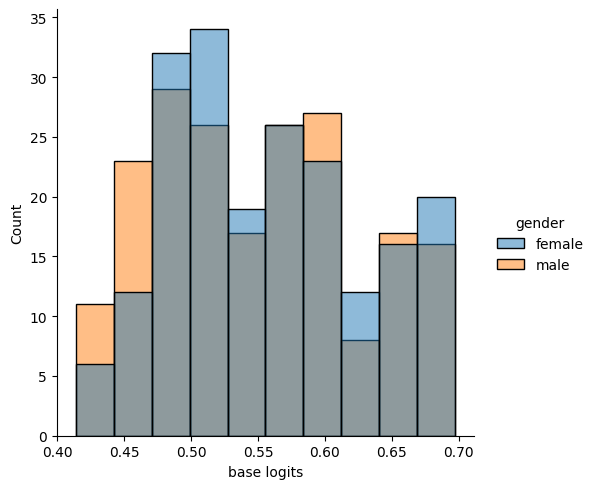

In [45]:
import seaborn as sns

sns.displot(data=logits_to_m_df, x='base logits', hue='gender')

In [46]:
logits_to_m_df.groupby('gender')['base logits'].mean()

gender
female    0.558173
male      0.548999
Name: base logits, dtype: float32

In [47]:
from scipy.stats import ttest_ind

ttest_ind(
    logits_to_m_df[logits_to_m_df['gender'] == 'male']['base logits'],
    logits_to_m_df[logits_to_m_df['gender'] == 'female']['base logits']
)

Ttest_indResult(statistic=-1.248865544269117, pvalue=0.2124483073951384)

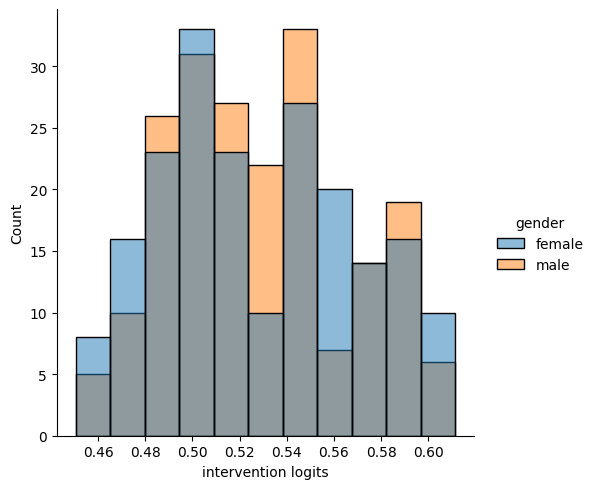

In [48]:
import seaborn as sns

sns.displot(data=logits_to_m_df, x='intervention logits', hue='gender')

In [49]:
logits_to_m_df.groupby('gender')['intervention logits'].mean()

gender
female    0.528034
male      0.528558
Name: intervention logits, dtype: float32

In [50]:
from scipy.stats import ttest_ind

ttest_ind(
    logits_to_m_df[logits_to_m_df['gender'] == 'male']['intervention logits'],
    logits_to_m_df[logits_to_m_df['gender'] == 'female']['intervention logits']
)

Ttest_indResult(statistic=0.13439874473131613, pvalue=0.8931552111292048)

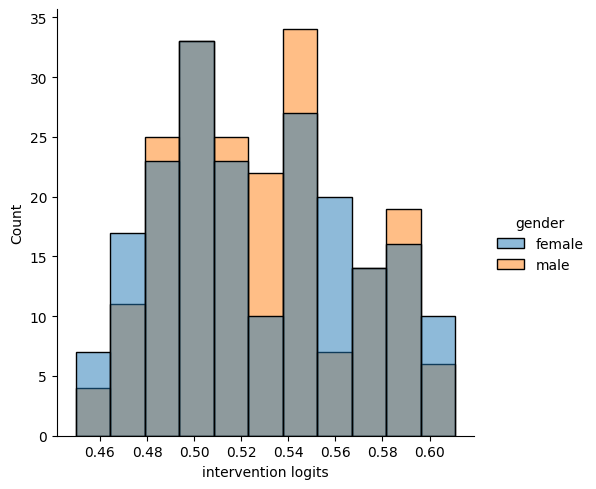

In [51]:
import seaborn as sns

sns.displot(data=logits_to_f_df, x='intervention logits', hue='gender')

In [52]:
logits_to_f_df.groupby('gender')['intervention logits'].mean()

gender
female    0.527524
male      0.528049
Name: intervention logits, dtype: float32

In [53]:
from scipy.stats import ttest_ind

ttest_ind(
    logits_to_f_df[logits_to_f_df['gender'] == 'male']['intervention logits'],
    logits_to_f_df[logits_to_f_df['gender'] == 'female']['intervention logits']
)

Ttest_indResult(statistic=0.13452087616507866, pvalue=0.8930587040784872)